In [270]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from math import exp, expm1

## 1. Load the dataset & label 2 classes

In [271]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/J-tin/CarryOn/Exuberance-in-Financial-Markets-Evidence-from-Machine-Learning-Algorithms/Data_SVM.csv")

# Delete the second row of the dataframe 
df = df_raw.iloc[1:]

# Rename the first row of the dataframe
df_new = df.rename(columns={'MSCI World ': 'Date', 'NDDUWI': 'monthly_price', 'MSCI WORLD U$ - PRICE/BOOK RATIO':'P/B', 'MSCI WORLD U$ - DIVIDEND YIELD':'div Y'})

# Dividend Yield devides by 100.
for i in range(len(df_new['div Y'])):
    df_new.loc[i+1,'div Y'] = float(df_new.loc[i+1,'div Y'])/100

### Calculate 1-month, 12-month, 60-month returns
lags = [1, 12, 60]

# Convert pandas.Series from object to float using pd.to_numeric(s, errors='coerce')
for lag in lags:
    df_new[f'return_{lag}m']=(pd.to_numeric(df_new['monthly_price'], errors='coerce').
                            pct_change(lag)
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
print(df_new.head(15))    # Reference link: https://books.google.de/books?id=tx2CDwAAQBAJ&pg=PA101&lpg=PA101&dq=compute+returns+for+various+holding+periods+using+python&source=bl&ots=uj8KrNq8ls&sig=ACfU3U0xMVTXnEjGPdLu8oqIRvXzjd3DaQ&hl=zh-CN&sa=X&ved=2ahUKEwijv5Cpzs7pAhWK-6QKHfDBAYwQ6AEwCnoECAkQAQ#v=onepage&q=compute%20returns%20for%20various%20holding%20periods%20using%20python&f=false

df_new.info()

          Date monthly_price   P/B  div Y  return_1m  return_12m  return_60m
1   1974/12/31         88.76  1.08  0.054        NaN         NaN         NaN
2    1975/1/31         101.7  1.22  0.047   0.145786         NaN         NaN
3    1975/2/28        110.68   1.3  0.044   0.088299         NaN         NaN
4    1975/3/31        111.49  1.29  0.044   0.007318         NaN         NaN
5    1975/4/30        116.11  1.33  0.042   0.041439         NaN         NaN
6    1975/5/30        118.86  1.35  0.041   0.023684         NaN         NaN
7    1975/6/30        120.36  1.37   0.04   0.012620         NaN         NaN
8    1975/7/31        113.71  1.31  0.042  -0.055251         NaN         NaN
9    1975/8/29        111.95  1.29  0.043  -0.015478         NaN         NaN
10   1975/9/30        107.25  1.24  0.044  -0.041983         NaN         NaN
11  1975/10/31        114.64  1.31  0.042   0.068904         NaN         NaN
12  1975/11/28        117.77  1.35   0.04   0.027303         NaN         NaN

### 1.1 Calculate the 25% quantile value in 3 cases

In [272]:
# Descriptive statistics (excluding NaN values)
stats = df_new.describe()
print(stats)

# Accessing 25% quantile value 
pi_1m = stats.loc['25%', 'return_1m']
pi_12m = stats.loc['25%', 'return_12m']
pi_60m = stats.loc['25%', 'return_60m']

print(pi_1m, pi_12m, pi_60m)

        return_1m  return_12m  return_60m
count  543.000000  532.000000  484.000000
mean     0.008518    0.007728    0.007680
std      0.042324    0.013395    0.005844
min     -0.189602   -0.051710   -0.004864
25%     -0.015959    0.000930    0.003734
50%      0.011869    0.009842    0.008067
75%      0.032548    0.015307    0.011092
max      0.145786    0.043124    0.024461
-0.015958936121823475 0.0009298932888119338 0.003734370341523685


### 1.2.1 Create a labelled table for 1-month investment: "df_1m"

In [273]:
# Create a datafram for 'return_1m'
obs_1m = stats.loc['count','return_1m']            # Observations of return_1m
df_1m = df_new[['P/B', 'div Y', 'return_1m']]      # Create a new datafram "df_1m" based on df_new
df_1m = df_1m.loc[0:obs_1m,:]                      # Slice the series until the 484th row, since the observations of Return_1m is 484.
return_1m_noNaN = df_new['return_1m'].dropna()     # Create a column vector "return_60m" from the dataframe 'df_new' and Drop NaN values
for i in range(len(df_1m['return_1m'])):           # Relocate the return_1m value 
    df_1m.iat[i,2] = return_1m_noNaN[i+2]
print(df_1m.tail())

# Add 'label' column in the datafram 'df_60m'
label = []                                         # Create a list "label" by comparing with 25% quantile return
for i in range(len(df_1m['return_1m'])):
    return_1m = df_1m.iat[i, 2]
    if return_1m >= pi_1m:                        
        label.append(0)                            # label = 0, if over 25%q, otherwise 1.
    else:
        label.append(1)

df_1m['label'] = label                             # Add a new column 'label' to the corresponding dataframe
df_1m = df_1m.apply(pd.to_numeric, errors='coerce')# Convert pandas.Serioes from dtype object to float, since ploting a scatter graph needs numeric values.
df_1m.tail()

      P/B   div Y  return_1m
539  2.47  0.0243   0.027851
540  2.53  0.0236   0.029958
541  2.57  0.0233  -0.006087
542  2.57  0.0234  -0.084524
543  2.34  0.0258  -0.132344


,P/B,div Y,return_1m,label
539,2.47,0.0243,0.027851,0
540,2.53,0.0236,0.029958,0
541,2.57,0.0233,-0.006087,0
542,2.57,0.0234,-0.084524,1
543,2.34,0.0258,-0.132344,1


### 1.2.2 Create a labelled table for 12-month investment: "df_12m"

In [274]:
# Create a datafram for 'return_12m'
obs_12m = stats.loc['count','return_12m']
df_12m = df_new[['P/B', 'div Y', 'return_12m']]
df_12m = df_12m.loc[0:obs_12m,:]
return_12m_noNaN = df_new['return_12m'].dropna()
for i in range(len(df_12m['return_12m'])):
    df_12m.iat[i,2] = return_12m_noNaN[i+13]
print(df_12m.tail())

# Add 'label' column in the datafram 'df_60m'
label = []
for i in range(len(df_12m['return_12m'])):
    return_12m = df_12m.iat[i, 2]
    if return_12m >= pi_12m:
        label.append(0)
    else:
        label.append(1)

df_12m['label'] = label                                
df_12m = df_12m.apply(pd.to_numeric, errors='coerce') 
df_12m.tail()

      P/B   div Y  return_12m
528  2.33  0.0253    0.011370
529  2.15  0.0276    0.020565
530   2.3  0.0259    0.013697
531  2.36  0.0254    0.003783
532  2.39  0.0251   -0.009100


,P/B,div Y,return_12m,label
528,2.33,0.0253,0.011370,0
529,2.15,0.0276,0.020565,0
530,2.30,0.0259,0.013697,0
531,2.36,0.0254,0.003783,0
532,2.39,0.0251,-0.009100,1


### 1.2.3 Create a labelled table for 60-month investment: "df_60m"

In [275]:
obs_60m = stats.loc['count','return_60m']
df_60m = df_new[['P/B', 'div Y', 'return_60m']]
df_60m = df_60m.loc[0:484,:]    
return_60m_noNaN = df_new['return_60m'].dropna() 
for i in range(len(df_60m['return_60m'])):   
    df_60m.iat[i,2] = return_60m_noNaN[i+61]
print(df_60m.tail())

# Add 'label' column in the datafram 'df_60m'
label = []
for i in range(len(df_60m['return_60m'])):
    return_60m = df_60m.iat[i, 2]
    if return_60m >= pi_60m:
        label.append(0)
    else:
        label.append(1)

df_60m['label'] = label  
df_60m = df_60m.apply(pd.to_numeric, errors='coerce')
df_60m.tail()

      P/B   div Y  return_60m
480  2.22  0.0237    0.006239
481  2.19  0.0241    0.007007
482  2.18  0.0244    0.007211
483  2.29  0.0233    0.004776
484  2.28  0.0237    0.002665


,P/B,div Y,return_60m,label
480,2.22,0.0237,0.006239,0
481,2.19,0.0241,0.007007,0
482,2.18,0.0244,0.007211,0
483,2.29,0.0233,0.004776,0
484,2.28,0.0237,0.002665,1


## 2. Visualize the "df_60m" dataset -- Scatter plot

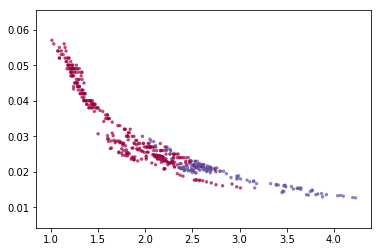

In [276]:
P_B = df_60m['P/B']
div_Y = df_60m['div Y']
label = df_60m['label']
plt.scatter(P_B,div_Y, c=label, cmap=plt.cm.Spectral,alpha=0.6, s=6)

# 0. Preprocess the data -- Scaling the data

In [277]:
# Create a numpy-array (matrix) X that contains 2 features  (x1,x2)
# Create a numpy-array (vector) Y that contains your labels (1,0)

from sklearn import preprocessing           
X_data_60m = df_60m.iloc[:,0:2].values           # (484,2) 
scaler = preprocessing.StandardScaler().fit(X_data_60m)
X_60m = scaler.transform(X_data_60m)
Y_60m = label.iloc[:484].values                 # (484,)

m = X.shape[0]                                  # Training set size
shape_X = X_60m.shape
shape_Y = Y_60m.shape                           # (484,1)

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (484, 2)
The shape of Y is: (484,)
I have m = 484 training examples!


##########################################################################################################

# Model 1: Simple logistic regression model

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model 
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

## 1.1 Define the logistic regression classifier

In [281]:
clf = sklearn.linear_model.LogisticRegressionCV()       # Solver lbfgs supports only 'l2' or 'none' penalties
clf.fit(X_60m, Y_60m)

LogisticRegressionCV()

## 1.2 Plot the decision boundary

Text(0.5, 1.0, 'Logistic Regression, Decision Boundary')

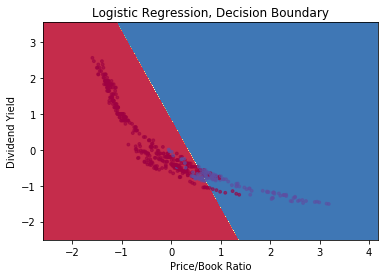

In [282]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X_60m.T, Y_60m.T)
plt.title("Logistic Regression, Decision Boundary")   

## 1.3 Evaluate the model (60-month case) _3-, 5-, 10-fold 
Reference：https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [283]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from keras.callbacks import EarlyStopping, ModelCheckpoint
%load_ext tensorboard
import statistics

# As a dict mapping the scorer name to the scoring function:
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc',
           'recall':'recall_macro'}

cv=[3,5,10]
for i in cv:
    cv_results = cross_validate(clf.fit(X_60m, Y_60m), X_60m, Y_60m, cv=i, scoring=scoring)

    test_accuracy = statistics.mean(cv_results['test_accuracy'])
    test_pre = statistics.mean(cv_results['test_prec'])
    test_f1 = statistics.mean(cv_results['test_F1'])
    test_auc = statistics.mean(cv_results['test_AUC'])
    test_recall = statistics.mean(cv_results['test_AUC'])

    print(str(i) + " Fold cross validation:")
    print("  Average Accuracy rate: %.2f%%" % (test_accuracy*100))
    print("  Average Prediction rate: %.2f%%" %(test_pre*100))
    print("  Average F1 score: %.2f%%" %(test_pre*100))
    print("  Average AUC: %.2f%%" %(test_pre*100))
    print("  Average Recall: %.2f%%" %(test_recall*100))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
3 Fold cross validation:
  Average Accuracy rate: 82.01%
  Average Prediction rate: 72.33%
  Average F1 score: 72.33%
  Average AUC: 72.33%
  Average Recall: 88.72%
5 Fold cross validation:
  Average Accuracy rate: 85.74%
  Average Prediction rate: 80.63%
  Average F1 score: 80.63%
  Average AUC: 80.63%
  Average Recall: 90.99%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 Fold cross validation:
  Average Accuracy rate: 84.59%
  Average Prediction rate: 62.32%
  Average F1 score: 62.32%
  Average AUC: 62.32%
  Average Recall: 91.57%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Brief Interpretation: 
The dataset is pretty linearly separable, so logistic regression does perform well. We expect a neural network will do better. 

####  测评估计量补充： F1 score, also known as balanced F-score or F-measure

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
F1 = 2 * (precision * recall) / (precision + recall)

Reference： https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

## 1.3.1 Evaluate the model (1-month case)

In [284]:
# Prepare the dataset
X_data_1m = df_1m.iloc[:,0:2].values
scaler = preprocessing.StandardScaler().fit(X_data_1m)
X_1m = scaler.transform(X_data_1m)
Y_1m = df_1m.iloc[:,3].values

# Define the model
clf = sklearn.linear_model.LogisticRegressionCV()    

# Train & Evaluate the dataset
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc'}

cv_results = cross_validate(clf.fit(X_1m, Y_1m), X_1m, Y_1m, cv=10, scoring=scoring)

test_accuracy = statistics.mean(cv_results['test_accuracy'])
test_pre = statistics.mean(cv_results['test_prec'])
test_f1 = statistics.mean(cv_results['test_F1'])
test_auc = statistics.mean(cv_results['test_AUC'])

print("Average Accuracy rate: %.2f%%" % (test_accuracy*100))
print("Average Prediction rate: %.2f%%" %(test_pre*100))
print("Average F1 score: %.2f%%" %(test_pre*100))
print("Average AUC: %.2f%%" %(test_pre*100))

F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

Average Accuracy rate: 74.96%
Average Prediction rate: 0.00%
Average F1 score: 0.00%
Average AUC: 0.00%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 1.3.2 Evaluate the model (12-month case)

In [285]:
# Prepare the dataset
X_data_12m = df_12m.iloc[:,0:2].values
scaler = preprocessing.StandardScaler().fit(X_data_12m)
X_12m = scaler.transform(X_data_12m)
Y_12m = df_12m.iloc[:,3].values

# Define the model 
clf = sklearn.linear_model.LogisticRegressionCV() 

# Train & evaluate the model
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc'}

cv_results = cross_validate(clf.fit(X_12m, Y_12m), X_12m, Y_12m, cv=10, scoring=scoring)

test_accuracy = statistics.mean(cv_results['test_accuracy'])
test_pre = statistics.mean(cv_results['test_prec'])
test_f1 = statistics.mean(cv_results['test_F1'])
test_auc = statistics.mean(cv_results['test_AUC'])

# Print the measures
print("Average Accuracy rate: %.2f%%" % (test_accuracy*100))
print("Average Prediction rate: %.2f%%" %(test_pre*100))
print("Average F1 score: %.2f%%" %(test_pre*100))
print("Average AUC: %.2f%%" %(test_pre*100))

F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

Average Accuracy rate: 72.17%
Average Prediction rate: 1.05%
Average F1 score: 1.05%
Average AUC: 1.05%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############################################################################################################

# Model 2: DNN with 2 hidden layers (16,16)

In [286]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.layers.core import Dense
from keras.callbacks import Callback
from keras import backend as K
import numpy 

In [287]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 2.1 Evaluate the model (60-month case)

### 2.1.1 KFOLD 10

In [288]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy = []
prediction = []
f1 = []
recall = []

for train, test in kfold.split(X_60m, Y_60m):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy', precision_m, f1_m, recall_m])
    
    # Fit the model
    model.fit(X_60m[train], Y_60m[train],validation_split=0.1, epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_60m[test], Y_60m[test], verbose=0)
    
    # Print the validation accuracy each time
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    # print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    
    accuracy.append(scores[1] * 100)
    prediction.append(scores[2] * 100)
    f1.append(scores[3] * 100)
    recall.append(scores[4] * 100)
    
print("Average accuracy rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(accuracy), numpy.std(accuracy)))
print("Average prediction rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(prediction), numpy.std(prediction)))
print("Average F1: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(f1), numpy.std(f1)))
print("Average recall: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(recall), numpy.std(recall)))

Average accuracy rate: 88.86% (+/- 4.63%)
Average prediction rate: 79.92% (+/- 11.27%)
Average F1: 76.82% (+/- 10.37%)
Average recall: 81.12% (+/- 11.35%)


### 2.1.2 KFOLD 5

In [289]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy = []
prediction = []
f1 = []
recall = []

for train, test in kfold.split(X_60m, Y_60m):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy', precision_m, f1_m, recall_m])
    
    # Fit the model
    model.fit(X_60m[train], Y_60m[train],validation_split=0.1, epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_60m[test], Y_60m[test], verbose=0)
    
    # Print the validation accuracy each time
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    # print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    
    accuracy.append(scores[1] * 100)
    prediction.append(scores[2] * 100)
    f1.append(scores[3] * 100)
    recall.append(scores[4] * 100)
    
print("Average accuracy rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(accuracy), numpy.std(accuracy)))
print("Average prediction rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(prediction), numpy.std(prediction)))
print("Average F1: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(f1), numpy.std(f1)))
print("Average recall: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(recall), numpy.std(recall)))

Average accuracy rate: 89.26% (+/- 3.35%)
Average prediction rate: 63.33% (+/- 15.16%)
Average F1: 62.56% (+/- 14.79%)
Average recall: 65.71% (+/- 15.00%)


### 2.1.3 KFOLD 3

In [244]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accuracy = []
prediction = []
f1 = []
recall = []

for train, test in kfold.split(X_60m, Y_60m):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy', precision_m, f1_m, recall_m])
    
    # Fit the model
    model.fit(X_60m[train], Y_60m[train],validation_split=0.1, epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_60m[test], Y_60m[test], verbose=0)
    
    # Print the validation accuracy each time
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    # print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    
    accuracy.append(scores[1] * 100)
    prediction.append(scores[2] * 100)
    f1.append(scores[3] * 100)
    recall.append(scores[4] * 100)
    
print("Average accuracy rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(accuracy), numpy.std(accuracy)))
print("Average prediction rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(prediction), numpy.std(prediction)))
print("Average F1: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(f1), numpy.std(f1)))
print("Average recall: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(recall), numpy.std(recall)))

Average accuracy rate: 88.43% (+/- 1.07%)
Average prediction rate: 51.56% (+/- 4.15%)
Average F1: 48.94% (+/- 3.44%)
Average recall: 53.92% (+/- 4.12%)


## 2.2 Evaluate the model (1-month case)

In [230]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy = []
prediction = []


for train, test in kfold.split(X_1m, Y_1m):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy', precision_m, f1_m, recall_m])

    # Fit the model
    model.fit(X_1m[train], Y_1m[train], validation_split=0.1, epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_1m[test], Y_1m[test], verbose=0)
    
    # Print the measures
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    # print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    
    accuracy.append(scores[1] * 100)
    prediction.append(scores[2] * 100)

print("Average accuracy rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(accuracy), numpy.std(accuracy)))
print("Average prediction rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(prediction), numpy.std(prediction)))


Average accuracy rate74.77% (+/- 1.05%)
Average prediction rate0.00% (+/- 0.00%)
Average F10.00% (+/- 0.00%)


## 2.2 Evaluate the model (12-month)

In [232]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy = []
prediction = []
f1 = []

for train, test in kfold.split(X_12m, Y_12m):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy', precision_m, f1_m, recall_m])

    # Fit the model
    model.fit(X_12m[train], Y_12m[train], validation_split=0.1, epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_12m[test], Y_12m[test], verbose=0)
    
    # Print the measures
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    # print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    
    accuracy.append(scores[1] * 100)
    prediction.append(scores[2] * 100)
    f1.append(scores[3] * 100)

print("Average accuracy rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(accuracy), numpy.std(accuracy)))
print("Average prediction rate: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(prediction), numpy.std(prediction)))
print("Average F1: "+ "%.2f%% (+/- %.2f%%)" % (numpy.mean(f1), numpy.std(f1)))

Average accuracy rate: 78.21% (+/- 3.19%)
Average prediction rate: 43.83% (+/- 24.34%)
Average F1: 23.95% (+/- 14.89%)


# Model 3: DNN with 2-hidden layers (12, 8)  by different alphas

In [126]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

## 3.1 Prepare & Split the dataset

In [266]:
datasets = [(X_60m, Y_60m)]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_60m, Y_60m, test_size=.2, random_state = 42)

## 3.2 Define the MLPClassifier 

In [267]:
h = .02  # step size in the mesh
alphas = np.logspace(-1, 0, 5)   # Specify 5 alphas values
names = ['alpha ' + str(i) for i in alphas]
classifiers = []

# Define a 2-hidden-layer NN model based on varying regularization (alpha) in MLPClassifier
for i in alphas:
    classifiers.append(make_pipeline(        #功能函数 make_pipeline 是构建管道的缩写; 它接收多个评估器并返回一个管道，自动填充评估器名
                       StandardScaler(),
                       MLPClassifier(solver='lbfgs',        #‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
                                     alpha=i,               # L2 penalty (regularization term) parameter   
                                     activation='logistic', # Activation function for the hidden layer. 
                                                            # 'logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
                                     random_state=1,        # Determines random number generation for weights and bias initialization, train-test split if early stopping is used
                                     max_iter=2000,         # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
                                     early_stopping=True,   # Whether to use early stopping to terminate training when validation score is not improving.
                                                             # True: it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.
                                     hidden_layer_sizes=[12, 8])))  # We build 2 hidden layers. 12 neurons in the 1st layer; 8 in the 2nd one.


## 3.3 Plot the 10 probability regimes by alphas

Test accuracy: 91.75%
Test accuracy: 91.75%
Test accuracy: 90.72%
Test accuracy: 89.69%
Test accuracy: 87.63%


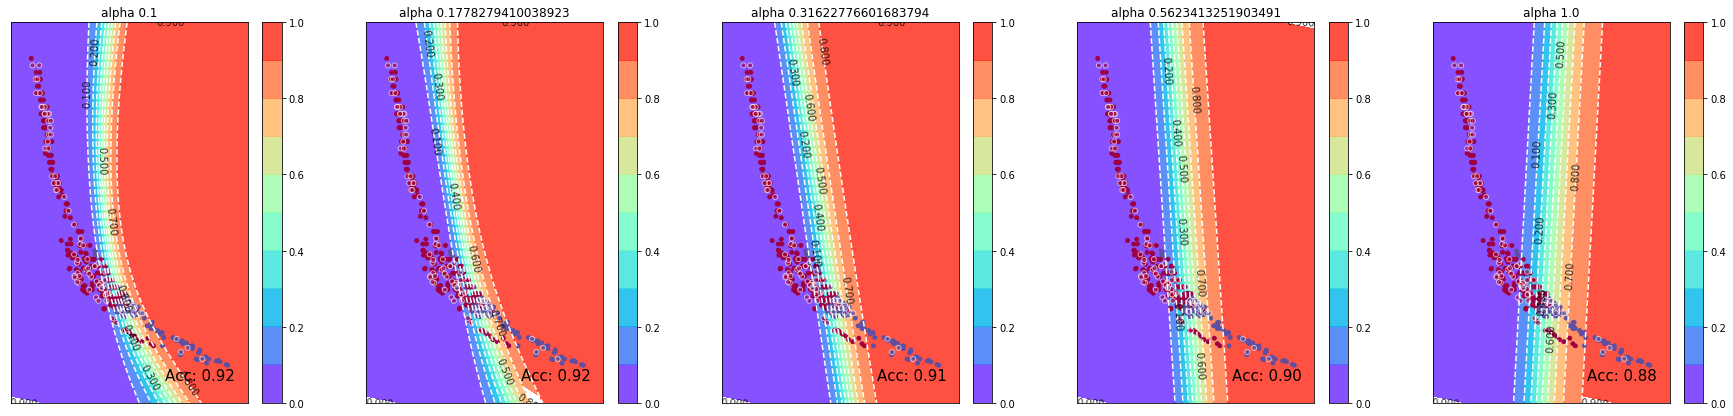

In [268]:
# Create a new figure with 30-inch width, 7-inch height
figure = plt.figure(figsize=(30, 7))  

# 设置横纵左边的长度及分段，根据数据长度而定
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# meshgrid函数就是用两个坐标轴上的点在平面上画网格(当然这里传入的参数是两个的时候)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),    # h = .02  step size in the mesh 网格中的步长
                         np.arange(y_min, y_max, h))


i = 1
# Iterate over classifiers
for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    ax = plt.subplot(1, 6, i)               # Add a subplot to the current figure 
    clf.fit(X_train, y_train)               # Train the model with automatically 10-fold cross validation which has been specidies in Classifiers
    score = clf.score(X_test, y_test)       # Evaluate the model by calculating the test accuracy
    
    print("Test accuracy: %.2f%%" % (score*100))
    

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predict_proba 是（软）分类器的一种方法，用于输出实例在每个类中的概率。

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cm = plt.cm.rainbow                # 设置彩色色谱
    contour = ax.contourf(xx, yy, Z, 10, cmap=cm, alpha=.8)    # contourf(X,Y,Z) 指定 Z 中各值的 x 和 y 坐标，10 means 10 regions
    ax.contour(contour, linestyles = 'dashed', colors='white') # Add line contours on the graph
    plt.clabel(contour,inline=True,fontsize=10,colors='k')    # Add labels to line contours in our ContourSet object
    figure.colorbar(contour, ax=ax)
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=15)
    
    # Plot the testing points with whilte edgecolors
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, alpha=0.6, edgecolors='white', s=25)

    # Set the limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('Acc: %.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    i += 1

figure.subplots_adjust(left=.02, right=.98)

# Display the plot
plt.show()

## 3.4 Select two optimal models: alpha = 0.3 & 1.3

### 3.4.1 Define the model list

In [269]:
h = .02  # step size in the mesh
alphas = [0.3, 1.3]   # Specify 5 alphas values
names = ['alpha ' + str(i) for i in alphas]
classifiers = []

for i in alphas:
    classifiers.append(make_pipeline(        #功能函数 make_pipeline 是构建管道的缩写; 它接收多个评估器并返回一个管道，自动填充评估器名
                       StandardScaler(),
                       MLPClassifier(solver='lbfgs',        #‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
                                     alpha=i,               # L2 penalty (regularization term) parameter   
                                     activation='logistic', # Activation function for the hidden layer. 
                                                            # 'logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
                                     random_state=1,        # Determines random number generation for weights and bias initialization, train-test split if early stopping is used
                                     max_iter=2000,         # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
                                     early_stopping=True,   # Whether to use early stopping to terminate training when validation score is not improving.
                                                             # True: it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.
                                     hidden_layer_sizes=[12, 8]))) 

### 3.4.1 Evaluate the model: KFOLD 10 _ 1-month case

In [265]:
# As a dict mapping the scorer name to the scoring function:
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc',
           'recall':'recall_macro'}

for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    cv_results = cross_validate(clf.fit(X_1m, Y_1m), X_1m, Y_1m, cv=10, scoring=scoring)

    test_accuracy = statistics.mean(cv_results['test_accuracy'])
    test_pre = statistics.mean(cv_results['test_prec'])

    print(" 10 Fold cross validation:")
    print("  Average Accuracy rate: %.2f%%" % (test_accuracy*100))
    print("  Average Prediction rate: %.2f%%" %(test_pre*100))

F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

 10 Fold cross validation:
  Average Accuracy rate: 70.88%
  Average Prediction rate: 2.11%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

 10 Fold cross validation:
  Average Accuracy rate: 74.96%
  Average Prediction rate: 0.00%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.4.2 Evaluate the model: KFOLD 10 _ 12-month case

In [264]:
# As a dict mapping the scorer name to the scoring function:
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc',
           'recall':'recall_macro'}

for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    cv_results = cross_validate(clf.fit(X_12m, Y_12m), X_12m, Y_12m, cv=10, scoring=scoring)

    test_accuracy = statistics.mean(cv_results['test_accuracy'])
    test_pre = statistics.mean(cv_results['test_prec'])

    print(" 10 Fold cross validation:")
    print("  Average Accuracy rate: %.2f%%" % (test_accuracy*100))
    print("  Average Prediction rate: %.2f%%" %(test_pre*100))

F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

 10 Fold cross validation:
  Average Accuracy rate: 69.53%
  Average Prediction rate: 1.52%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being

 10 Fold cross validation:
  Average Accuracy rate: 71.98%
  Average Prediction rate: 1.25%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.4.3 Evaluate the model: KFOLD 3/5/10 _ 60-month case

In [256]:
for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    print("Classifier: " + str(clf[1]))
    
    cv=[3,5,10]
    for i in cv:
        cv_results = cross_validate(clf.fit(X_60m, Y_60m), X_60m, Y_60m, cv=i, scoring=scoring)

        test_accuracy = statistics.mean(cv_results['test_accuracy'])
        test_pre = statistics.mean(cv_results['test_prec'])
        test_f1 = statistics.mean(cv_results['test_F1'])
        test_auc = statistics.mean(cv_results['test_AUC'])
        test_recall = statistics.mean(cv_results['test_AUC'])

        print(str(i) + " Fold cross validation:")
        print("  Average Accuracy rate: %.2f%%" % (test_accuracy*100))
        print("  Average Prediction rate: %.2f%%" %(test_pre*100))
        print("  Average F1 score: %.2f%%" %(test_pre*100))
        print("  Average AUC: %.2f%%" %(test_pre*100))
        print("  Average Recall: %.2f%%" %(test_recall*100))

Classifier: MLPClassifier(activation='logistic', alpha=0.3, early_stopping=True,
              hidden_layer_sizes=[12, 8], max_iter=2000, random_state=1,
              solver='lbfgs')
3 Fold cross validation:
  Average Accuracy rate: 80.96%
  Average Prediction rate: 63.48%
  Average F1 score: 63.48%
  Average AUC: 63.48%
  Average Recall: 83.34%
5 Fold cross validation:
  Average Accuracy rate: 83.27%
  Average Prediction rate: 75.58%
  Average F1 score: 75.58%
  Average AUC: 75.58%
  Average Recall: 89.27%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 Fold cross validation:
  Average Accuracy rate: 82.72%
  Average Prediction rate: 70.28%
  Average F1 score: 70.28%
  Average AUC: 70.28%
  Average Recall: 90.74%
Classifier: MLPClassifier(activation='logistic', alpha=1.3, early_stopping=True,
              hidden_layer_sizes=[12, 8], max_iter=2000, random_state=1,
              solver='lbfgs')
3 Fold cross validation:
  Average Accuracy rate: 86.34%
  Average Prediction rate: 79.48%
  Average F1 score: 79.48%
  Average AUC: 79.48%
  Average Recall: 90.93%
5 Fold cross validation:
  Average Accuracy rate: 87.18%
  Average Prediction rate: 85.53%
  Average F1 score: 85.53%
  Average AUC: 85.53%
  Average Recall: 92.05%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 Fold cross validation:
  Average Accuracy rate: 85.64%
  Average Prediction rate: 63.85%
  Average F1 score: 63.85%
  Average AUC: 63.85%
  Average Recall: 91.67%


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.4.4  Plot the probability regimes

Test accuracy: 90.72%
Test accuracy: 88.66%


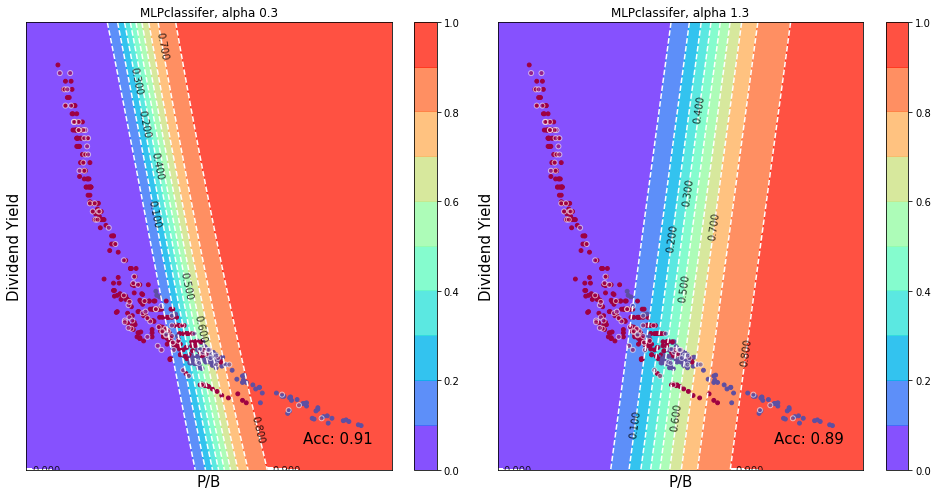

In [91]:
# Create a new figure with 30-inch width, 7-inch height
figure = plt.figure(figsize=(20, 7))  

# 设置横纵左边的长度及分段，根据数据长度而定
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# meshgrid函数就是用两个坐标轴上的点在平面上画网格(当然这里传入的参数是两个的时候)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),    # h = .02  step size in the mesh 网格中的步长
                         np.arange(y_min, y_max, h))

i = 1
# Iterate over classifiers
for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    ax = plt.subplot(1, 3, i)               # Add a subplot to the current figure 
    
    # Train the model with automatically 10-fold cross validation which has been specidies in Classifiers
    clf.fit(X_train, y_train)  
    
    # Evaluate the model by calculating the test accuracy
    score = clf.score(X_test, y_test)       
    
    print("Test accuracy: %.2f%%" % (score*100))
    
    # Plot the decision boundary. For that, we will assign a color to each. point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predict_proba 是（软）分类器的一种方法，用于输出实例在每个类中的概率。

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cm = plt.cm.rainbow                # 设置彩色色谱
    contour = ax.contourf(xx, yy, Z, 10, cmap=cm, alpha=.8)    # contourf(X,Y,Z) 指定 Z 中各值的 x 和 y 坐标，10 means 10 regions
    ax.contour(contour, linestyles = 'dashed', colors='white') # Add line contours on the graph
    plt.clabel(contour,inline=True,fontsize=10,colors='k')    # Add labels to line contours in our ContourSet object
    figure.colorbar(contour, ax=ax)
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=15)
    
    # Plot the testing points with whilte edgecolors
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, alpha=0.6, edgecolors='white', s=25)
    
    # Set the limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel('P/B', fontsize=15)
    ax.set_ylabel('Dividend Yield', fontsize=15)
    ax.set_title('MLPclassifer'+', '+ name)
    ax.text(xx.max() - .3, yy.min() + .3, ('Acc: %.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    i += 1

figure.subplots_adjust(left=.05, right=.95)

# Display the plot
plt.show()